## Lab 2

### Poetry generation

Let's try to generate some poetry using RNNs and The Shakespeare sonnets

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [4]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2024-02-08 18:13:39--  https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.02s   

2024-02-08 18:13:39 (4.96 MB/s) - ‘sonnets.txt’ saved [119748/119748]



Let's reduce the complexity of the task and lowercase all the symbols.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join([x for x in text]).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that we've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
idx_to_token = {i: token for i, token in enumerate(tokens)}

# dict <char>:<index>
token_to_idx = {token: i for i, token in enumerate(tokens)}

In [8]:
sentences = []
next_tokens = []
for i in range(0, len(text) - 64, 1):
    sentences.append(text[i : i + 64])
    next_tokens.append(text[i + 64])

x = np.zeros((len(sentences), 64, len(tokens)))
y = np.zeros((len(sentences), len(tokens)))

for i, sentence in enumerate(sentences):
    for t, token in enumerate(sentence):
        x[i, t, token_to_idx[token]] = 1
    y[i, token_to_idx[next_tokens[i]]] = 1

In [9]:
print(x.shape)

(100161, 64, 38)


### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN

In [10]:
class RNN(nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 128, emb_dim = 128, n_layers = 1):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = n_tokens

        self.embed = nn.Embedding(n_tokens, self.emb_dim)
        self.rnn = nn.RNN(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.dropout  = nn.Dropout(.35)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)

    def forward(self, x, h_prev):
        h_seq, h = self.rnn(self.embed(x), h_prev)
        h_seq = self.dropout(h_seq)
        next_logits = self.hid_to_logits(h_seq)
        return next_logits, h

    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)

In [11]:
def get_batches(x, y, device, batch_size, batch_ind):
    x_batch = torch.argmax(torch.Tensor(x[batch_ind - batch_size : batch_ind]), dim = -1).to(device)
    y_batch = torch.argmax(torch.Tensor(y[batch_ind - batch_size : batch_ind]), dim = -1).to(device)

    return x_batch, y_batch

In [12]:
def train_model(model, epochs=100):
    torch.manual_seed(7)
    batch_size = 512
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    loss_history = []

    model.train()

    for epoch in range(1, epochs+1):
        curr_loss = []
        hidden_state = model.initial_state(batch_size)

        for batch_ind in range(batch_size, x.shape[0], batch_size):
            optimizer.zero_grad()
            x_batch, y_batch = get_batches(x, y, device, batch_size, batch_ind)

            optimizer.zero_grad()
            seq, hidden_state = model(x_batch, hidden_state)
            loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())
            loss.backward()
            optimizer.step()
            curr_loss.append(loss.item())
            hidden_state = hidden_state.detach()

        loss_history.append(np.mean(curr_loss))
        if epoch % 5 == 0:
            print(f'epoch {epoch}')
            print(f'loss {loss_history[-1]}')

    #visualize
    plt.figure(figsize=(18,7))
    plt.plot(loss_history, label = 'loss')
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

epoch 5
loss 1.8748918398832664
epoch 10
loss 1.7851137827604244
epoch 15
loss 1.7421311329572629
epoch 20
loss 1.7091854725128566
epoch 25
loss 1.6888371204718566
epoch 30
loss 1.6720387684993254
epoch 35
loss 1.6601778788444324
epoch 40
loss 1.6506259533075185
epoch 45
loss 1.6403353416002713
epoch 50
loss 1.6311144657624073


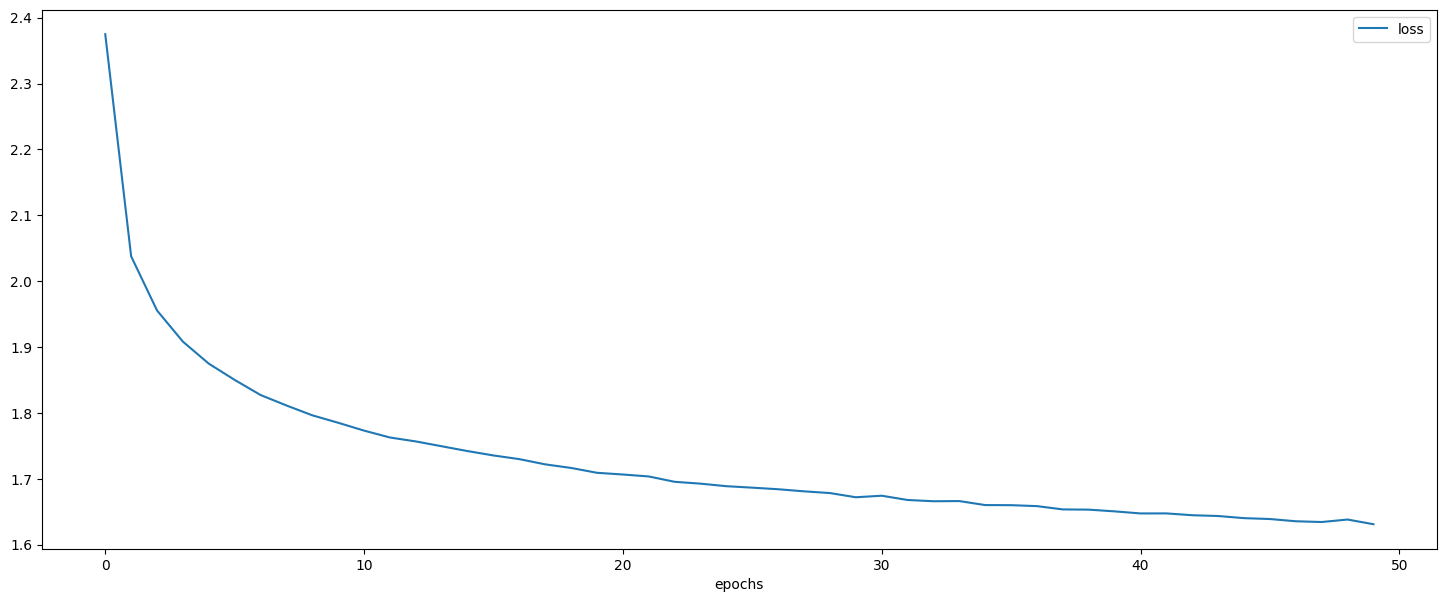

In [13]:
model_rnn = RNN()
model_rnn.to(device)

epochs = 50

train_model(model_rnn, epochs)

In [14]:
def generate_text(char_rnn, tokens = tokens, seed_phrase = 'darling, ', max_length = 100, temperature = 1., flag = False):
    x_sequence = torch.Tensor([np.array([token_to_idx[token] for token in seed_phrase.lower()])]).to(device)
    hid_state = char_rnn.initial_state(batch_size = 1)

    if flag: hid_state = tuple([each.data for each in hid_state])

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(torch.stack([x_sequence[:, -1].long()]), hid_state)
        preds =  F.softmax(out / temperature, dim = -1).cpu().data.numpy().squeeze()
        next_ix_ = np.random.choice(len(tokens), p = preds)
        next_ix = torch.LongTensor([[next_ix_]])

        x_sequence = torch.cat([x_sequence, next_ix.to(device)], dim = 1)

    return ''.join([tokens[int(ix)] for ix in x_sequence.cpu().data.numpy()[0]])

In [15]:
model_rnn.eval()
print(generate_text(char_rnn = model_rnn,  max_length = 500, temperature = 1.))

<ipython-input-14-e0185a019bab>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  x_sequence = torch.Tensor([np.array([token_to_idx[token] for token in seed_phrase.lower()])]).to(device)


darling, love excade:
    but mistance coefoly mobhings vares and that formey fell.
   fate;
  it dear that stalled fortane i atsequout wanded dear love twiese oser more what for hey thou meitied, froil trterpebmiin.

  night's knownorress utlend,
  where faire;
  that i in of thy boey for vili

  in pettain the tendels no eyes hnoos thy faivich from thee, but i polusing thou syounding; soll need my i love thee angeating gay not of lovess ere love seatttable,
  but firest bube thou uster dewirn 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [16]:
class LSTM (nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 256, emb_dim = 128, n_layers = 1):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = emb_dim
        self.embed = nn.Embedding(n_tokens, self.emb_dim)
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)

    def forward(self, x, hidden_state):
        out, hidden_state = self.lstm(self.embed(x), hidden_state)
        out = self.hid_to_logits(out)
        return out, hidden_state

    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [17]:
def train_model_lstm(model, epochs=100):
    torch.manual_seed(7)
    batch_size = 512
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    loss_history = []

    model.train()

    for epoch in range(1, epochs+1):
        curr_loss = []
        hidden_state = model.initial_state(batch_size)

        for batch_ind in range(batch_size, x.shape[0], batch_size):
            x_batch, y_batch = get_batches(x, y, device, batch_size, batch_ind)
            hidden_state = tuple([each.data for each in hidden_state])

            optimizer.zero_grad()
            seq, hidden_state = model_lstm(x_batch, hidden_state)
            loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())
            loss.backward()
            optimizer.step()
            curr_loss.append(loss.item())

        loss_history.append(np.mean(curr_loss))
        if epoch % 5 == 0:
            print(f'epoch {epoch}')
            print(f'loss {loss_history[-1]}')

    #visualize
    plt.figure(figsize=(18,7))
    plt.plot(loss_history, label = 'loss')
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

epoch 5
loss 1.514732805887858
epoch 10
loss 1.3301099917827508
epoch 15
loss 1.2053706150788528
epoch 20
loss 1.0865384982182429
epoch 25
loss 0.9684581484550084
epoch 30
loss 0.8822192127888019
epoch 35
loss 0.8026916482509711
epoch 40
loss 0.7259531360406142
epoch 45
loss 0.6627356446706332
epoch 50
loss 0.6167711062309069


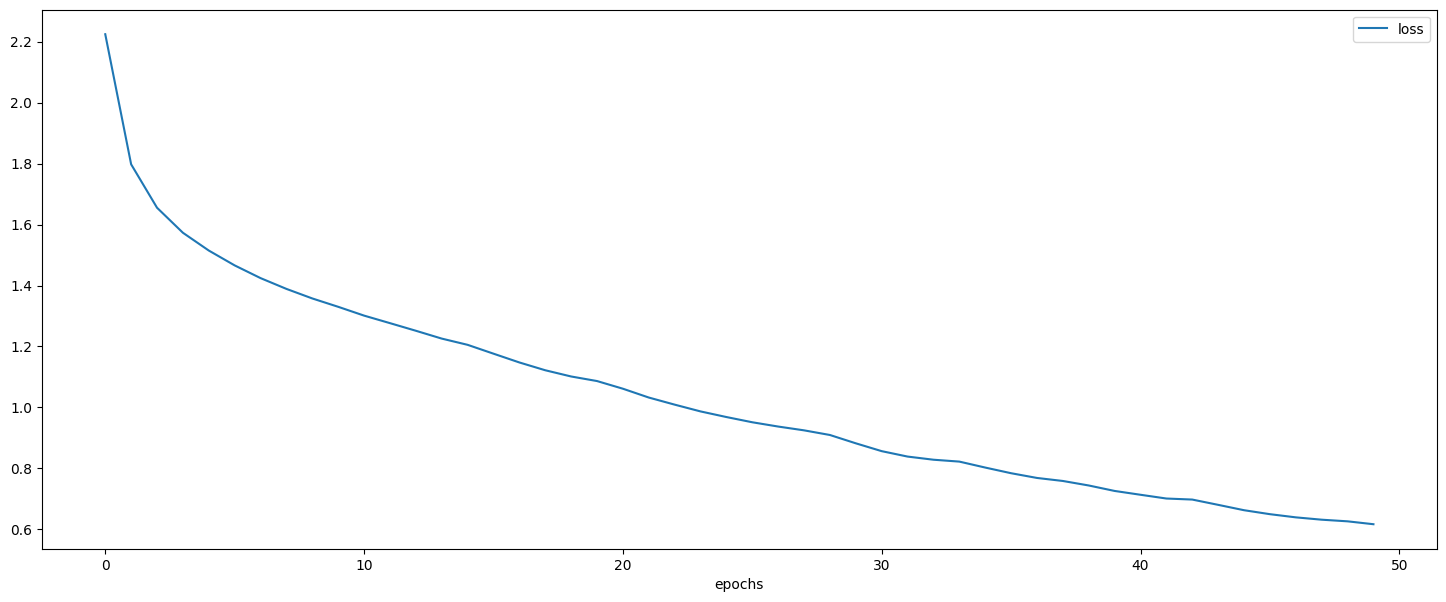

In [18]:
model_lstm = LSTM()
model_lstm.to(device)

epochs = 50

train_model_lstm(model_lstm, epochs)

Now generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`

In [19]:
model_lstm.eval()

for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print("TEMPERATURE = ", temperature)
    poetry = generate_text(char_rnn = model_lstm, temperature = temperature, max_length = 400, seed_phrase = "Darling, ")

    print('\t', poetry, '\n')

TEMPERATURE =  0.1
	 darling, truth so sun andress
  to thy sweet self to love, when it flowers doth she,
    and my sins and see where all thy self to self-say,
  for therefore mistation thy sweet self doth lie,
  which shall is and my poor love's will grown'd,
  cannot be so any seat, for forgot as dead.

  cxxxi

  my love is as a fever longing still,
  and sweet feast in my self thou dost hath her die,
  to love,  

TEMPERATURE =  0.2
	 darling, true sight,
  and sweet self to love, thy heart in thy deserts reason'd,
  if it were in thy sinful loving thy sins,
    so thou art make the world an endrour, which he dour'd with thy sweet,
  that have present our false to art, and do should love to some is the stard
  and surse before have was thy ransom allame,
  and dead the light, when i have sweet die,
  looking on their false shal 

TEMPERATURE =  0.5
	 darling, truth so song.
  if yet, love is as a nellow ad my part
  or me thus express'd with too much strongly beauty new;
  that h

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [20]:
def save_net(net, name: str, opt):
    checkpoint = {'state_dict': net.state_dict(),
                  'opt_state_dict': opt.state_dict()}

    with open(name, 'wb') as f:
        torch.save(checkpoint, f)

In [21]:
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
save_net(model_lstm, "LSTM.net", optimizer)

checkpoint = torch.load("LSTM.net")
model_lstm.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['opt_state_dict'])
model_lstm.eval()

LSTM(
  (embed): Embedding(38, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (hid_to_logits): Linear(in_features=256, out_features=38, bias=True)
)

In [22]:
print(generate_text(char_rnn = model_lstm, temperature = 1., max_length = 450, seed_phrase = "Darling! "))

darling! joy spends;
  no longer hath hot have sweet love doth lines she starvethers upher:
    all think thou hast anwaste of lines that lover's dearest,
  in purest haste my costs, now is thou art forsworn down.
  to mar the world, or imperfect love to love.
    there-beren im seemily with true hearts should:
  they moursh with worses not to pen might it all forsee,
  do not be so found the liken some in these will'd,
  and i strength and thee 


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)